In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as tfrms
from torchvision import datasets
import torch.nn.functional as F



class DCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(DCNN, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization layer
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fourth Convolutional Block (Additional layer for more capacity)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        # Adjust input size based on the output of the last pooling layer
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Adjusted for new conv layers
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.fc2 = nn.Linear(512, num_classes)
        

    def forward(self, x):
        # Convolutional layers with ReLU activation and BatchNorm
        x = self.pool1(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.leaky_relu(self.bn4(self.conv4(x))))


        # Flatten the tensor
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer

        # Fully connected layers with eLU and Dropout
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Step 2: Preprocess and load data
transform = tfrms.Compose([
    tfrms.Resize((64, 64)),    
    tfrms.ToTensor(),
    tfrms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



train_data = datasets.ImageFolder(root='./train', transform=transform)
train_loader = DataLoader(
   train_data, 
   batch_size=32, 
   shuffle=True, 
   num_workers=4, 
   pin_memory=True
)

# Model, Loss, and Optimization Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DCNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(
   model.parameters(), 
   lr=1e-3, 
   weight_decay=0.01
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
   optimizer, 
   T_max=10, 
   eta_min=1e-5
)

# Step 4: Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

# Step 5: Save the model (optional)
torch.save(model.state_dict(), 'road_sign_model.pth')

Epoch [1/10], Loss: 2.316516468922297
Epoch [2/10], Loss: 0.8030481189489365
Epoch [3/10], Loss: 0.6159582113226255
Epoch [4/10], Loss: 0.5618491321802139
Epoch [5/10], Loss: 0.5173633173108101
Epoch [6/10], Loss: 0.48399964223305386
Epoch [7/10], Loss: 0.4598679045836131
Epoch [8/10], Loss: 0.451831616461277
Epoch [9/10], Loss: 0.427933136622111
Epoch [10/10], Loss: 0.40318434437115985


Test The Model

In [ ]:
# Load the model
model = DCNN()
model.load_state_dict(torch.load('road_sign_model.pth'))
model.eval()  # Set the model to evaluation mode

test_data = datasets.ImageFolder(root='./test', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation for evaluation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        total += labels.size(0)  # Total number of labels
        correct += (predicted == labels).sum().item()  # Count correct predictions

accuracy = 100 * correct / total
print(f'Accuracy on test dataset: {accuracy:.2f}%')

NameError: name 'DCNN' is not defined

In [ ]:
# Load the model
model = DCNN()
model.load_state_dict(torch.load('road_sign_model.pth'))
model.eval()  # Set the model to evaluation mode

test_data = datasets.ImageFolder(root='./testCorrected', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation for evaluation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        total += labels.size(0)  # Total number of labels
        correct += (predicted == labels).sum().item()  # Count correct predictions

accuracy = 100 * correct / total
print(f'Accuracy on test dataset: {accuracy:.2f}%')

NameError: name 'DCNN' is not defined

In [73]:
from PIL import Image

# Load and preprocess a single image
image_path = './test/0/00000_00000_00001.jpg'
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  # Add batch dimension

# Get the model's prediction
model.eval()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)
    class_idx = predicted.item()

# Get the class name from your dataset
class_name = test_data.classes[class_idx]
print(f'Predicted class: {class_name}')

Predicted class: 2


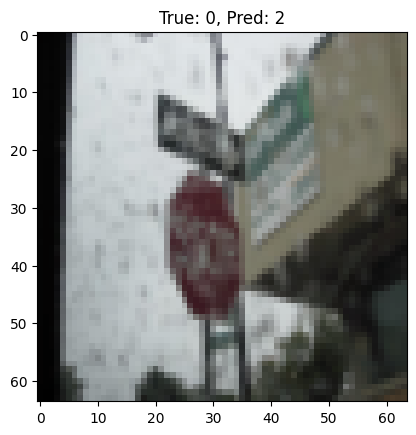

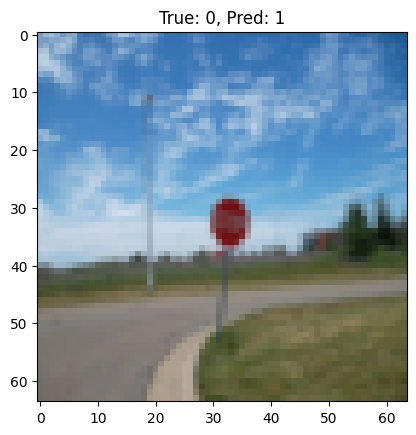

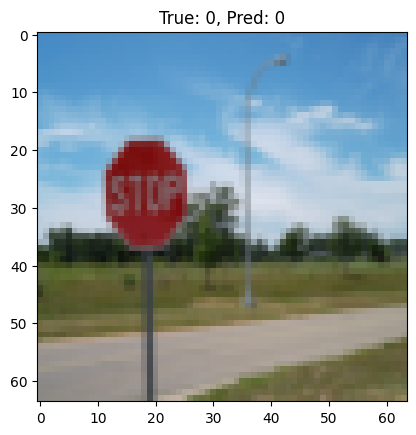

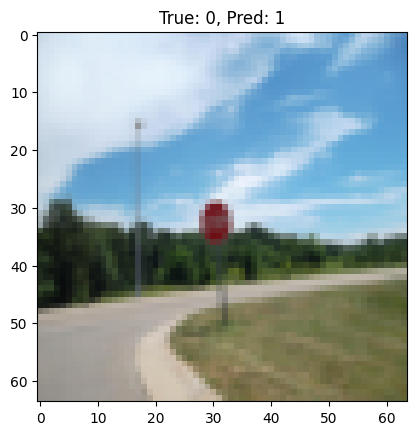

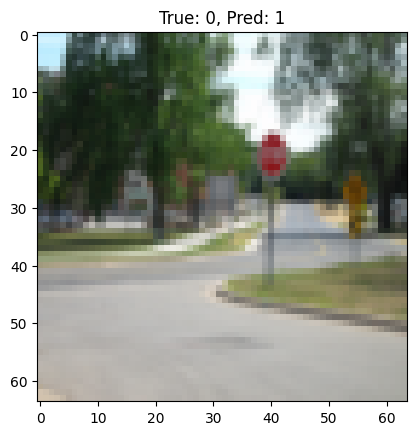

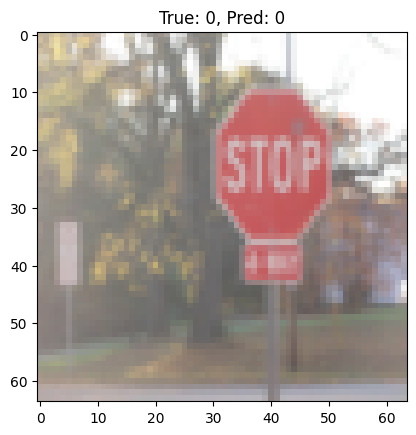

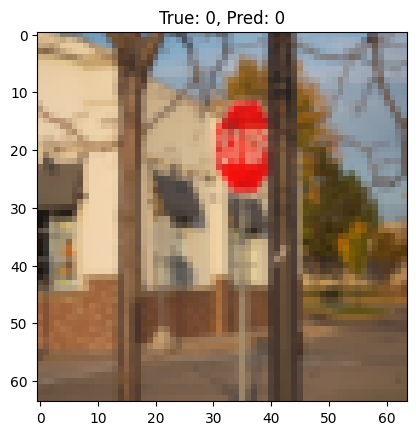

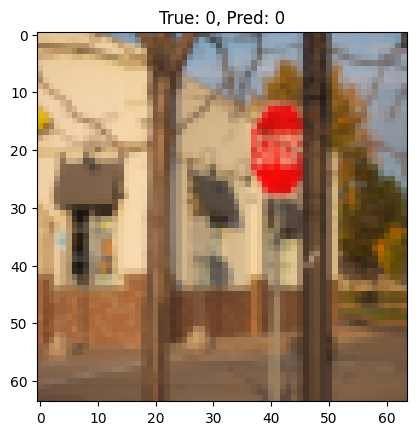

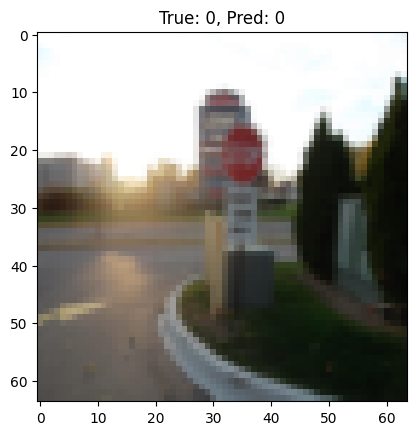

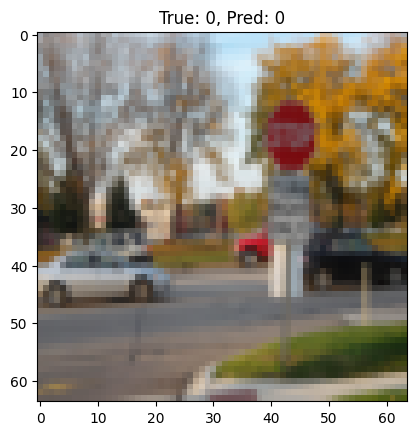

In [74]:
import matplotlib.pyplot as plt

def imshow(img, label, prediction):
    img = img.permute(1, 2, 0)  # Change shape for display
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
    plt.imshow(img.numpy())
    plt.title(f'True: {label}, Pred: {prediction}')
    plt.show()

# Display some test images with predictions
for images, labels in test_loader:
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    for i in range(10):  # Show first 4 images in the batch
        imshow(images[i], test_data.classes[labels[i]], test_data.classes[predictions[i]])
    break